# Miniprojeto AD/RF

### Grupo:
#### - Caio Rocha Calado
#### - Gabriel Ayres Barbosa
#### - Emanoel Thyago Cordeiro dos Santos
#### - Mateus Araújo Neves
#### - Rafael Ramos Batista Corcino

# Importando as Bibliotecas

In [111]:
!pip install optuna

In [112]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
import optuna
from optuna.visualization import (
    plot_contour,
    plot_edf,
    plot_intermediate_values,
    plot_optimization_history,
    plot_parallel_coordinate,
    plot_param_importances,
    plot_rank,
    plot_slice,
    plot_timeline,
)

# Análise Inicial dos Dados

In [113]:
# Carregando os arquivos
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
target_test = pd.read_csv('/content/gender_submission.csv')

In [114]:
print(train_df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [115]:
print(train_df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [116]:
print(train_df.nunique())

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64


# Pré-processamento dos Dados

In [117]:
# Remover colunas irrelevantes
train_df = train_df.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

# Criar uma nova coluna binária indicando se há informação na coluna 'Cabin'
train_df['Has_Cabin'] = train_df['Cabin'].notna().astype(int)

# Remover a coluna 'Cabin' original
train_df = train_df.drop(['Cabin'], axis=1)

# Preencher valores ausentes na coluna 'Age' com a média
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].mean())

# Remover linhas restantes com valores ausentes
train_df = train_df.dropna()

# Convertendo variáveis categóricas para variáveis dummy (one-hot encoding)
train_df = pd.get_dummies(train_df, columns=['Sex', 'Embarked'])

# Garantindo que todos os dados sejam do tipo float
train_df = train_df.astype(float)

# Separar as classes
df_majority = train_df[train_df['Survived'] == 0.0]
df_minority = train_df[train_df['Survived'] == 1.0]

# Aplicar Oversampling na classe minoritária
df_minority_upsampled = resample(df_minority,
                                 replace=True,  # Permite duplicação
                                 n_samples=len(df_majority),  # Igualar ao tamanho da maioria
                                 random_state=42)

# Combinar os datasets balanceados
train_df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Verificar se ficou balanceado
print(train_df_balanced['Survived'].value_counts())


Survived
0.0    549
1.0    549
Name: count, dtype: int64


In [118]:
print(train_df.head())

   Survived  Pclass   Age  SibSp  Parch     Fare  Has_Cabin  Sex_female  \
0       0.0     3.0  22.0    1.0    0.0   7.2500        0.0         0.0   
1       1.0     1.0  38.0    1.0    0.0  71.2833        1.0         1.0   
2       1.0     3.0  26.0    0.0    0.0   7.9250        0.0         1.0   
3       1.0     1.0  35.0    1.0    0.0  53.1000        1.0         1.0   
4       0.0     3.0  35.0    0.0    0.0   8.0500        0.0         0.0   

   Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0       1.0         0.0         0.0         1.0  
1       0.0         1.0         0.0         0.0  
2       0.0         0.0         0.0         1.0  
3       0.0         0.0         0.0         1.0  
4       1.0         0.0         0.0         1.0  


In [119]:
# Separar features e target
features = train_df_balanced.drop(columns=['Survived'])
target = train_df_balanced['Survived']

# Converter features para numpy para melhor desempenho
features_np = features.to_numpy()
target_np = target.to_numpy()

# Árvore de Decisão

In [120]:
# Definir KFold para 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Função objetivo para Optuna
def objective(trial):
    # Definir hiperparâmetros a serem otimizados
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 50)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)  # Correção aqui
    min_impurity_decrease = trial.suggest_float('min_impurity_decrease', 0.0, 0.1)

    accuracies = []

    # Cross-validation
    for train_idx, val_idx in kf.split(features_np):
        X_train, X_val = features_np[train_idx], features_np[val_idx]
        y_train, y_val = target_np[train_idx], target_np[val_idx]

        # Criar modelo
        model = DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            criterion=criterion,
            max_leaf_nodes=max_leaf_nodes,
            max_features=max_features,
            min_impurity_decrease=min_impurity_decrease,
            random_state=42
        )

        # Treinamento
        model.fit(X_train, y_train)

        # Avaliação no conjunto de validação
        y_val_pred = model.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        accuracies.append(val_accuracy)

    # Retornar a média das acurácias nos folds
    return np.mean(accuracies)

# Otimização com Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Melhores hiperparâmetros encontrados
best_tree_params = study.best_params
print(f"Melhores hiperparâmetros: {best_tree_params}")

[I 2025-03-24 17:22:25,633] A new study created in memory with name: no-name-ca85908f-2b97-4979-8a50-301eaa4e081b
[I 2025-03-24 17:22:25,650] Trial 0 finished with value: 0.77230801162308 and parameters: {'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'entropy', 'max_leaf_nodes': 22, 'max_features': 0.8135793298189173, 'min_impurity_decrease': 0.08331417880926792}. Best is trial 0 with value: 0.77230801162308.
[I 2025-03-24 17:22:25,665] Trial 1 finished with value: 0.77230801162308 and parameters: {'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 4, 'criterion': 'entropy', 'max_leaf_nodes': 30, 'max_features': 0.4101677628361583, 'min_impurity_decrease': 0.07050253268812894}. Best is trial 0 with value: 0.77230801162308.
[I 2025-03-24 17:22:25,681] Trial 2 finished with value: 0.7741344956413448 and parameters: {'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 10, 'criterion': 'entropy', 'max_leaf_nodes': 9, 'max_features': 0.8088275

Melhores hiperparâmetros: {'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 8, 'criterion': 'gini', 'max_leaf_nodes': 9, 'max_features': 0.9241511678417927, 'min_impurity_decrease': 0.00219473410329488}


# Testando o melhor modelo no conjunto de teste:

In [121]:
# Remover colunas irrelevantes
test_df = test_df.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

# Criar uma nova coluna binária indicando se há informação na coluna 'Cabin'
test_df['Has_Cabin'] = test_df['Cabin'].notna().astype(int)

# Remover a coluna 'Cabin' original
test_df = test_df.drop(['Cabin'], axis=1)

# Preencher valores ausentes na coluna 'Age' com a média
test_df['Age'] = test_df['Age'].fillna(test_df['Age'].mean())

# Preencher valores ausentes na coluna 'Fare' com a moda
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].mode()[0])

# Convertendo variáveis categóricas para variáveis dummy (one-hot encoding)
test_df = pd.get_dummies(test_df, columns=['Sex', 'Embarked'])

# Garantir que todas as colunas do conjunto de teste estejam presentes no treinamento
missing_cols = set(train_df.columns) - set(test_df.columns)
for col in missing_cols:
    test_df[col] = 0  # Adiciona colunas faltantes com valor 0

# Ordenar as colunas na mesma ordem do treino
test_df = test_df[train_df.columns.drop('Survived')]  # Remove 'Survived', pois está apenas no treino

# Separar o alvo
target_test = target_test['Survived']

In [122]:
# Treinando o modelo com os melhores hiperparâmetros
best_tree = DecisionTreeClassifier(**best_tree_params, random_state=42)
best_tree.fit(features, target)

# Realizar previsões
predictions = best_tree.predict(test_df)

# Calcular as métricas de avaliação
accuracy = accuracy_score(target_test, predictions)
precision = precision_score(target_test, predictions)
recall = recall_score(target_test, predictions)
f1 = f1_score(target_test, predictions)
roc_auc = roc_auc_score(target_test, predictions)

# Exibir as métricas
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

Acurácia: 0.9091
Precisão: 0.8434
Recall: 0.9211
F1-Score: 0.8805
AUC-ROC: 0.9117


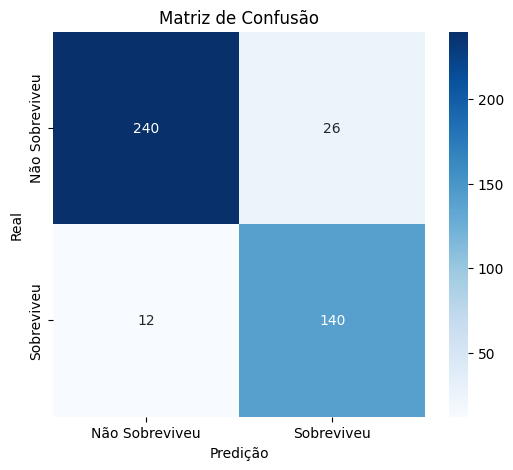

In [123]:
# Calcular a matriz de confusão
cm = confusion_matrix(target_test, predictions)

# Exibir a matriz de confusão como um gráfico
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Sobreviveu', 'Sobreviveu'], yticklabels=['Não Sobreviveu', 'Sobreviveu'])
plt.title('Matriz de Confusão')
plt.xlabel('Predição')
plt.ylabel('Real')
plt.show()

In [124]:
plot_optimization_history(study)

In [125]:
plot_edf(study)

In [126]:
plot_parallel_coordinate(study)

In [127]:
plot_param_importances(study)

In [128]:
plot_contour(study)

# Random Forest

In [129]:
# Definir KFold para 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Função objetivo para Optuna
def objective(trial):
    # Definir hiperparâmetros ajustados para reduzir overfitting
    n_estimators = trial.suggest_int('n_estimators', 50, 200)  # Mínimo maior para mais estabilidade
    max_depth = trial.suggest_int('max_depth', 2, 20)  # Reduzir profundidade
    min_samples_split = trial.suggest_int('min_samples_split', 5, 20)  # Evitar divisões pequenas
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 15)  # Evitar folhas pequenas
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 5, 50)  # Evitar árvores muito complexas
    max_features = trial.suggest_float('max_features', 0.1, 0.8)  # Limitar features por árvore
    min_impurity_decrease = trial.suggest_float('min_impurity_decrease', 0.01, 0.1)  # Evitar divisões fracas
    bootstrap = trial.suggest_categorical('bootstrap', [True])  # Manter bootstrap ativado

    accuracies = []

    # Cross-validation
    for train_idx, val_idx in kf.split(features_np):
        X_train, X_val = features_np[train_idx], features_np[val_idx]
        y_train, y_val = target_np[train_idx], target_np[val_idx]

        # Criar modelo Random Forest ajustado
        model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            criterion=criterion,
            max_leaf_nodes=max_leaf_nodes,
            max_features=max_features,
            min_impurity_decrease=min_impurity_decrease,
            bootstrap=bootstrap,
            random_state=42,
            n_jobs=-1
        )

        # Treinamento
        model.fit(X_train, y_train)

        # Avaliação no conjunto de validação
        y_val_pred = model.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        accuracies.append(val_accuracy)

    # Retornar a média das acurácias nos folds
    return np.mean(accuracies)

# Otimização com Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Melhores hiperparâmetros encontrados
best_forest_params = study.best_params
print(f"Melhores hiperparâmetros: {best_forest_params}")


[I 2025-03-24 17:22:32,743] A new study created in memory with name: no-name-9ba176d5-9eb5-43c8-836b-34cf5e4151b2
[I 2025-03-24 17:22:33,984] Trial 0 finished with value: 0.77230801162308 and parameters: {'n_estimators': 80, 'max_depth': 13, 'min_samples_split': 12, 'min_samples_leaf': 3, 'criterion': 'entropy', 'max_leaf_nodes': 11, 'max_features': 0.5675239295381913, 'min_impurity_decrease': 0.08005709769380542, 'bootstrap': True}. Best is trial 0 with value: 0.77230801162308.
[I 2025-03-24 17:22:35,092] Trial 1 finished with value: 0.7759609796596096 and parameters: {'n_estimators': 75, 'max_depth': 16, 'min_samples_split': 12, 'min_samples_leaf': 8, 'criterion': 'gini', 'max_leaf_nodes': 21, 'max_features': 0.2104616466291332, 'min_impurity_decrease': 0.02127713320572383, 'bootstrap': True}. Best is trial 1 with value: 0.7759609796596096.
[I 2025-03-24 17:22:37,129] Trial 2 finished with value: 0.77230801162308 and parameters: {'n_estimators': 156, 'max_depth': 2, 'min_samples_spli

Melhores hiperparâmetros: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 16, 'min_samples_leaf': 14, 'criterion': 'entropy', 'max_leaf_nodes': 11, 'max_features': 0.766281629171707, 'min_impurity_decrease': 0.010254138681433673, 'bootstrap': True}


In [130]:
# Treinando o modelo com os melhores hiperparâmetros
best_forest = RandomForestClassifier(**best_forest_params, random_state=42)
best_forest.fit(features, target)

# Realizar previsões
predictions = best_forest.predict(test_df)

# Calcular as métricas de avaliação
accuracy = accuracy_score(target_test, predictions)
precision = precision_score(target_test, predictions)
recall = recall_score(target_test, predictions)
f1 = f1_score(target_test, predictions)
roc_auc = roc_auc_score(target_test, predictions)

# Exibir as métricas
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

Acurácia: 0.9378
Precisão: 0.8795
Recall: 0.9605
F1-Score: 0.9182
AUC-ROC: 0.9427
